This notebook converts `samples.npy` to `fingerprints.npy`. After processing, check the max and mean images to make sure that you are not over- or under-cropping the data. Set `crop_rows` or `crop_cols` to `None` to see all the data.

In [1]:
data_root = 'drumData'
n_fft = 1024
hop_length = n_fft/4
use_logamp = False # boost the brightness of quiet sounds
reduce_rows = 10 # how many frequency bands to average into one
reduce_cols = 1 # how many time steps to average into one
crop_rows = 32 # limit how many frequency bands to use
crop_cols = 32 # limit how many time steps to use
limit = None # set this to 100 to only process 100 samples

In [2]:
%matplotlib inline
from utils import *
from tqdm import *
from os.path import join
from matplotlib import pyplot as plt
from skimage.measure import block_reduce
from multiprocessing import Pool
import numpy as np
import librosa

In [3]:
drumNames = ["kick", "tom", "snare", "clap", "hi.hat", "ride", "crash"]
drumFingerPrints = {}
drumSamples = {}
for d in drumNames:
    %time drumSamples[d] = np.load(join(data_root, d+'_samples.npy'))

CPU times: user 1.18 ms, sys: 201 ms, total: 203 ms
Wall time: 301 ms
CPU times: user 519 µs, sys: 16.1 ms, total: 16.7 ms
Wall time: 26.2 ms
CPU times: user 503 µs, sys: 92 ms, total: 92.5 ms
Wall time: 149 ms
CPU times: user 1.03 ms, sys: 50.9 ms, total: 51.9 ms
Wall time: 78.3 ms
CPU times: user 619 µs, sys: 6.73 ms, total: 7.35 ms
Wall time: 11.1 ms
CPU times: user 511 µs, sys: 8.4 ms, total: 8.91 ms
Wall time: 14.7 ms
CPU times: user 471 µs, sys: 27.5 ms, total: 28 ms
Wall time: 43.5 ms


In [4]:
window = np.hanning(n_fft)
def job(y):
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window)
    amp = np.abs(S)
    if reduce_rows > 1 or reduce_cols > 1:
        amp = block_reduce(amp, (reduce_rows, reduce_cols), func=np.mean)
    if amp.shape[1] < crop_cols:
        amp = np.pad(amp, ((0, 0), (0, crop_cols-amp.shape[1])), 'constant')
    amp = amp[:crop_rows, :crop_cols]
    if use_logamp:
        amp = librosa.logamplitude(amp**2)
    amp -= amp.min()
    if amp.max() > 0:
        amp /= amp.max()
    amp = np.flipud(amp) # for visualization, put low frequencies on bottom
    return amp

for d in drumNames:
    pool = Pool()
    %time fingerprints = pool.map(job, drumSamples[d][:limit])
    fingerprints = np.asarray(fingerprints).astype(np.float32)
    drumFingerPrints[d] = fingerprints
    print "generated finger print for", d, fingerprints.shape

CPU times: user 266 ms, sys: 268 ms, total: 534 ms
Wall time: 1.73 s
generated finger print for kick (5158, 32, 32)
CPU times: user 24.1 ms, sys: 22.2 ms, total: 46.3 ms
Wall time: 125 ms
generated finger print for tom (422, 32, 32)
CPU times: user 133 ms, sys: 146 ms, total: 279 ms
Wall time: 730 ms
generated finger print for snare (2546, 32, 32)
CPU times: user 68.5 ms, sys: 70.2 ms, total: 139 ms
Wall time: 391 ms
generated finger print for clap (1324, 32, 32)
CPU times: user 11.9 ms, sys: 9.16 ms, total: 21.1 ms
Wall time: 53.9 ms
generated finger print for hi.hat (159, 32, 32)
CPU times: user 16.3 ms, sys: 13.1 ms, total: 29.4 ms
Wall time: 79 ms
generated finger print for ride (228, 32, 32)
CPU times: user 42.5 ms, sys: 46 ms, total: 88.5 ms
Wall time: 376 ms
generated finger print for crash (723, 32, 32)


In [6]:
for d in drumNames:
    np.save(join(data_root, d+'_fingerprints.npy'), drumFingerPrints[d])
    print "saved", d+'_fingerprints.npy'

saved kick_fingerprints.npy
saved tom_fingerprints.npy
saved snare_fingerprints.npy
saved clap_fingerprints.npy
saved hi.hat_fingerprints.npy
saved ride_fingerprints.npy
saved crash_fingerprints.npy


data shape: (5158, 32, 32)
mean:


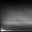

max:


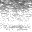

random selection:


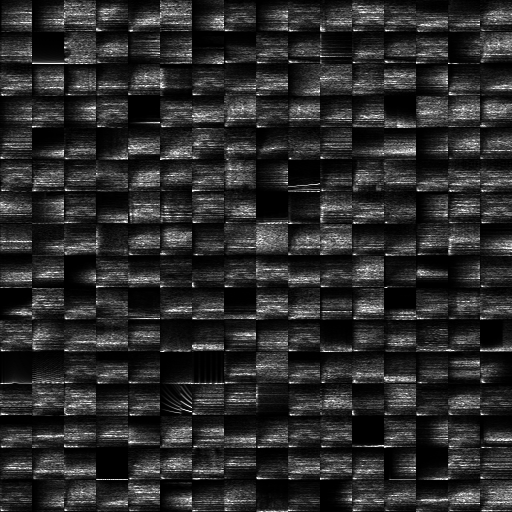

In [6]:
print 'data shape:', np.shape(drumFingerPrints[drumNames[0]])

mean = np.mean(fingerprints, axis=0)
mean -= mean.min()
mean /= mean.max()

print 'mean:'
show_array(255 * mean)
print 'max:'
show_array(255 * np.max(fingerprints, axis=0))

print 'random selection:'
indices = range(len(fingerprints))
np.random.shuffle(indices)
show_array(255 * make_mosaic(np.array(fingerprints)[indices], n=16))